# Additional Visualizations

This notebook will detail some extra statistics and visuals from our dataset. We'll need some imports to get things set up.

In [ ]:
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import panel as pn
import panel.widgets as pnw
import polars as pl

Here's a look at our dataset one last time

In [ ]:
reviews_path = '../data/Steam Game Reviews export 2025-09-20 21-34-15.csv' # Replace with the path to your reviews CSV File
game_metadata_path = '../data/games_description.csv' # Replace with path to game metadata CSV file, NOTE make sure to go to parent dir in the path


steamreviews = pd.read_csv(reviews_path)
gamemetadata = pd.read_csv(game_metadata_path)
steamdataset = pd.merge(steamreviews, gamemetadata, left_on='game_name', right_on='name', how='left')
steamdataset.drop(columns=['name'], inplace=True)

steamdataset

,review,hours_played,helpful,funny,recommendation,date,game_name,username,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,The game itself is also super fun. The PvP and...,39.9,1152,13,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Sentinowl\n224 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
1,Never cared much about Warhammer until this ga...,91.5,712,116,Recommended,13 September,"Warhammer 40,000: Space Marine 2",userpig\n248 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
2,A salute to all the fallen battle brothers who...,43.3,492,33,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Imparat0r\n112 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
3,this game feels like it was made in the mid 20...,16.8,661,15,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Fattest_falcon,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
4,Reminds me of something I've lost. A genuine g...,24.0,557,4,Recommended,12 September,"Warhammer 40,000: Space Marine 2",Jek\n410 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992148,2022 Early Access Review Loads of fun!Initiall...,4.2,1,0,Recommended,"August 4, 2022",Turbo Golf Racing,"Fatal Exit\n1,902 products in account",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992149,2022 Early Access Review Great fun!,8.5,1,0,Recommended,"August 4, 2022",Turbo Golf Racing,cleybaR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992150,2022 Early Access Review Excellent pick up and...,83.3,2,0,Recommended,"August 4, 2022",Turbo Golf Racing,Sim\n600 products in account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992151,2022 Early Access Review This game is so much ...,3.8,1,0,Recommended,"August 4, 2022",Turbo Golf Racing,Fatboybadboy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll need to do some preprocessing for the data:

In [21]:
steamdataset["genres"] = steamdataset["genres"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

steamdataset["release_year"] = steamdataset["release_date"].astype(str).str[-4:]
steamdataset["release_year"] = pd.to_numeric(steamdataset["release_year"], errors="coerce")

rating_map = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4,
    'Positive': 3,
    'Mixed': 2,
    'Negative': 1,
    'Very Negative': 0
}
steamdataset["rating_num"] = steamdataset["overall_player_rating"].map(rating_map)

#days since release (relative to when this code is run)
current_year = pd.Timestamp.today().year
steamdataset["days_since_release"] = (
    (current_year - steamdataset["release_year"]) * 365
)

steamdataset[["overall_player_rating", "rating_num", "release_year", "days_since_release"]].head(50000)

,overall_player_rating,rating_num,release_year,days_since_release
0,Very Positive,4.0,2024.0,365.0
1,Very Positive,4.0,2024.0,365.0
2,Very Positive,4.0,2024.0,365.0
3,Very Positive,4.0,2024.0,365.0
4,Very Positive,4.0,2024.0,365.0
...,...,...,...,...
49995,Mixed,2.0,2022.0,1095.0
49996,Mixed,2.0,2022.0,1095.0
49997,Mixed,2.0,2022.0,1095.0
49998,Mixed,2.0,2022.0,1095.0


### Graph 1

Finding the average ratio of recommended vs non-recommended games by genre and release year

To solve this, we'l employ a heatmap

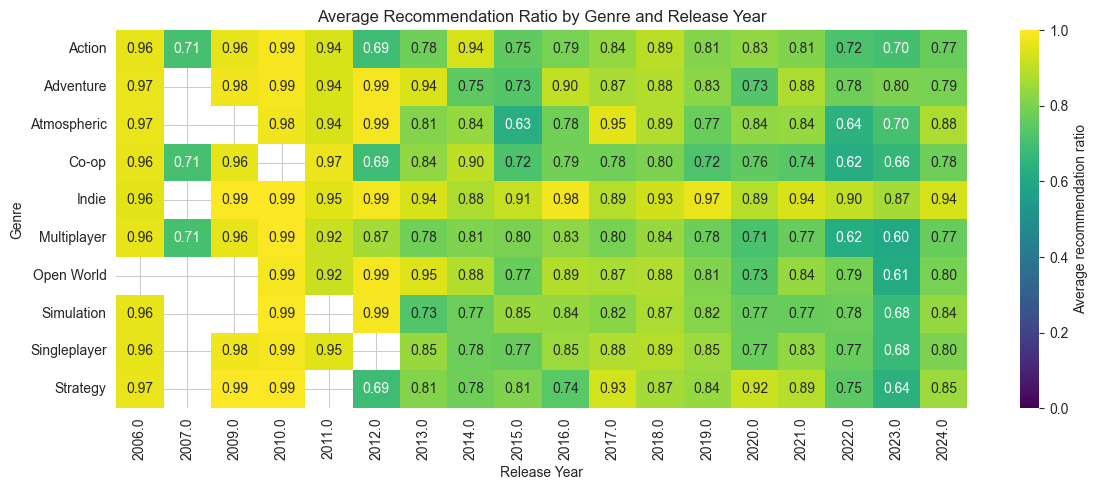

In [23]:
sns.set_style("whitegrid")

steamdataset["rec_ratio"] = steamdataset["recommendation"].map({
        "Recommended": 1,
        "Not Recommended": 0
    })
exploded = steamdataset.explode("genres")

#top 10 genres by frequency
top_genres = exploded["genres"].value_counts().head(10).index.tolist()
top_genre_df = exploded[exploded["genres"].isin(top_genres)].copy()

#compute mean rec_ratio by (genre, release_year)
heat_df = top_genre_df.groupby(["genres", "release_year"])["rec_ratio"].mean().reset_index()

heat_pivot = heat_df.pivot(
    index="genres",
    columns="release_year",
    values="rec_ratio"
)

plt.figure(figsize=(12, 5))
sns.heatmap(
    heat_pivot,
    cmap="viridis",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Average recommendation ratio"}
)
plt.title("Average Recommendation Ratio by Genre and Release Year")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

### Graph 2

Interactive plotly graph between rec_ratio and hours played